# Predict the Critical Temperature of a Superconductor with Random Forest
This notebook will reproduce and improve the Random Forest results of `predict_tc` in the Python language.

The paper makes these points about random forest implementation.

> Scalability and speed are important advantages of using XGBoost over random forests

In [1]:
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from xgboost import XGBRegressor

# Local Modules
from pyplot_data import plot_observed_vs_predicted
from read_data import load_and_split

>**Out-Of_sample RMSE Estimation Procedure**
>1. At random divide the data into 2/3 train and 1/3 test data.

In [15]:
training_X, training_y, testing_X, testing_y = load_and_split(verbose=True, file="./dataset_reduced.csv")

Data Shape: (15542, 82)
Training Features Shape: (10257, 81)
Training Labels Shape: (10257, 1)
Testing Features Shape: (5285, 81)
Testing Labels Shape: (5285, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


>2. Fit the model using the train data.

The paper mentions that the model with the lowest out-of-sample rmse was obtained with the following parameters.
>$\eta$ = 0.02, maximum depth = 16, minimum child weight = 1, column subsampling = 0.50, and a tree size of 374.

We will first train a model with these parameters.

In [16]:
xgb_lowest_rmse = XGBRegressor(
    learning_rate = 0.02,
    max_depth = 16,
    min_child_weight = 1,
    n_estimators=374,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    colsample_bynode=0.5
)
xgb_lowest_rmse.fit(training_X, training_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=16, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=374, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [12]:
# Load Model (Uncomment when needed)
# with open("../models/xgb_lowest_rmse_reduced_data.pkl", "rb") as f:
#     xgb_lowest_rmse = pickle.load(f)

In [17]:
# Save Model (Uncomment when needed)
# with open("../models/xgb_lowest_rmse_reduced_data.pkl", "wb") as f:
#     pickle.dump(xgb_lowest_rmse, f)

>3. Predict $T_c$ of the test data.

Score: 0.9274432735944297


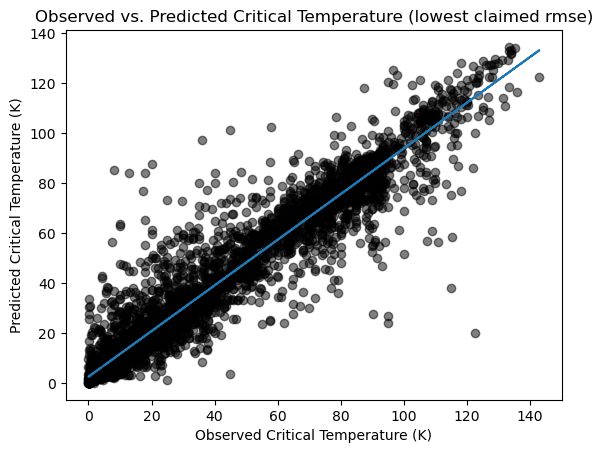

In [13]:
# Generates prediction using xgboost.
prediction_xgb_lowest_rmse = xgb_lowest_rmse.predict(testing_X)

print(f"Score: {xgb_lowest_rmse.score(testing_X, testing_y)}")

plot_observed_vs_predicted(
    testing_y,
    prediction_xgb_lowest_rmse,
    title="Observed vs. Predicted Critical Temperature (lowest claimed rmse)"
)

> 4. Obtain an estimate of the out-of-sample mean-squared-error (mse) by using the predictions from the last step and the observed $T_c$ values in the test data:
>$$out\;of\;sample\;mse=Average\;of\;(observed-predicted)^2$$

In [14]:
mse_xgb_lowest_rmse = mean_squared_error(testing_y, prediction_xgb_lowest_rmse)

print(f"Current MSE: {mse_xgb_lowest_rmse}")
print(f"Current RMSE: {np.sqrt(mse_xgb_lowest_rmse)}")

Current MSE: 83.1480168332003
Current RMSE: 9.118553439729368


> 5. Repeat steps 1 through 4, 25 times to collect 25 out-of-sample mse's.

In [8]:
mse_xgb_lowest_rmse_values = []
for index in tqdm(range(25)):
    training_X, training_y, testing_X, testing_y = load_and_split(random_state=index, file="./dataset_reduced.csv")
    xgb_lowest_rmse = XGBRegressor(
        learning_rate = 0.02,
        max_depth = 16,
        min_child_weight = 1,
        n_estimators=374,
        colsample_bytree=0.5,
        colsample_bylevel=0.5,
        colsample_bynode=0.5
    )
    xgb_lowest_rmse.fit(training_X, training_y)
    prediction_xgb_lowest_rmse = xgb_lowest_rmse.predict(testing_X)
    mse_xgb_lowest_rmse_values.append(mean_squared_error(testing_y, prediction_xgb_lowest_rmse))


100%|██████████| 25/25 [47:04<00:00, 112.97s/it]


> 6. Take the mean of the 25 collected out-of-sample mse's and report the square root of this average as the final estimate of the out-of-sample-rmse.

In [9]:
print(mse_xgb_lowest_rmse_values)

[82.47654361635762, 76.82964557653304, 79.64615997385872, 85.33448046623128, 82.948022289724, 88.03939484742915, 85.86648945343245, 84.95227662496063, 82.71872213386692, 90.89887357234444, 88.839247935662, 93.7617322934871, 86.52442564025206, 91.22620946081645, 89.35192988765985, 87.56825075932434, 83.53675781891812, 88.51679567559725, 81.15646494508555, 95.16054130820488, 83.65780054372887, 86.62732390183929, 91.25388905653098, 95.23247613150222, 83.1480168332003]


In [10]:
print(f"XGBoost RMSE: {np.sqrt(np.mean(mse_xgb_lowest_rmse_values))}")

XGBoost RMSE: 9.306497667214122
